# Evidence calculation for EFT expansions

<div style="text-align: center !important;"><img src="fitting_an_elephant_quote.png"></div>

## The toy model

Here we continue to explore aspects of Bayesian statistical analysis using toy models for effective field theories (EFTs), namely Taylor series of some specified functions. In this notebook we are exploring the evidence for how many coefficients in the EFT expansion are determined by the given data. 

Let's first review the function we are using as a toy model, taken from [*Bayesian parameter estimation for effective field theories*](https://arxiv.org/abs/1511.03618):

$$
g(x) = \left(\frac12 + \tan\left(\frac{\pi}{2}x\right)\right)^2
$$

represents the true, underlying theory.  It has a Taylor expansion

$$
g(x) = 0.25 + 1.57x + 2.47x^2 + 1.29 x^3 + \cdots
$$

Our model for an EFT for this "theory" is

$$
g_{\rm th}(x) \equiv \sum_{i=0}^k a_i x^i \;.
$$

In mini-project I, our general task was to fit 1, 2, 3, ... of the parameters $a_i$ and to analyze the results.

$% Some LaTeX definitions we'll use.
\newcommand{\pr}{{p}}  %\newcommand{\pr}{\textrm{p}}
\newcommand{\abar}{\bar a}
\newcommand{\avec}{{\bf a}}
\newcommand{\kmax}{k_{\rm max}}
$



## The statistical model (recap)


Here we are given data with simple error bars, which imply that the probability for any *single* data point is a normal distribution about the true value. That is,

$$
y_i \sim \mathcal{N}(y_M(x_i;\theta), \varepsilon_i)
$$

or, in other words,

$$
\pr(x_i\mid y_i, \theta) = \frac{1}{\sqrt{2\pi\varepsilon_i^2}} \exp\left(\frac{-\left[y_i - y_M(x_i;\theta)\right]^2}{2\varepsilon_i^2}\right)
$$

where $\varepsilon_i$ are the (known) measurement errors indicated by the error bars.


Assuming all the points are independent, we can find the full likelihood by multiplying the individual likelihoods together:

$$
\pr(D\mid\theta) = \prod_{i=1}^N \pr(x_i,y_i | \theta)
$$

For convenience and numerical accuracy, this is usually expressed in terms of the log-likelihood:

$$
\log \pr(D\mid\theta) = -\frac{1}{2}\sum_{i=1}^N\left(\log(2\pi\varepsilon_i^2) + \frac{\left[y_i - y_M(x_i;\theta)\right]^2}{\varepsilon_i^2}\right)
$$


We consider two priors for the coefficients.  The first is a Gaussian prior that encodes naturalness through the parameter $\abar$:

$$
\pr(\avec\mid \abar, I) = \left(\frac{1}{\sqrt{2\pi}\abar}\right)^{k+1} \exp{\left(-\frac{\avec^2}{2\abar^2}\right)}
$$

with $\abar$ taken to be fixed (at $\abar_{\rm fix} = 5$ usually).  That is, the prior pdf for $\abar$ is

$$
\pr(\abar) = \delta(\abar - \abar_{\rm fix}) \;.
$$

(In more recent work, we have used a conjugate prior for $\abar$ that simplifies the calculations.)

The second is an uninformative uniform prior that we take to be a constant (cutting it off only at very high values, which
may not even be needed).
Given likelihood and prior, the posterior pdf by Bayes' Theorem is

$$
\pr(\avec\mid D, k, \kmax, I) = \frac{\pr(D\mid \avec, k, \kmax, I)\; \pr(\avec\mid I)}{\pr(D \mid k, \kmax, I)}
$$

We have focused previously on calculating this posterior to find distributions for the coefficients $\theta = \{a_0, a_1, \cdots, a_k\}$. 
Furthermore, up to now we have ignored the denominator, which is the *evidence*, because we didn't need to calculate it independently.  Now we will calculate it.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn; seaborn.set("talk") # for plot formatting
import scipy.stats as stats
from scipy import linalg

from cycler import cycler
from matplotlib.cm import get_cmap


## The Data and the true result

Let's start by defining the exact function and the data for the toy model.

In [2]:
def g_fun(x):
    """
    Toy function to model an EFT expansion.  It has a Taylor expansion about
    x=0 with a radius of convergence of 1.
    """
    return (0.5 + np.tan(np.pi * x / 2.))**2

def y_model(x_pts, theta, orders=None):
    """
    Returns the evaluation of the theoretical model at all x values in the
    numpy array x_pts, using orders coefficients from theta (defaults to all).
    """
    if orders is None:   # allow for not using the full theta vector
        orders = len(theta)
        
    return np.array( [ np.sum(
                               [theta[i] * x**i for i in range(orders)]
                             ) for x in x_pts ] )
    

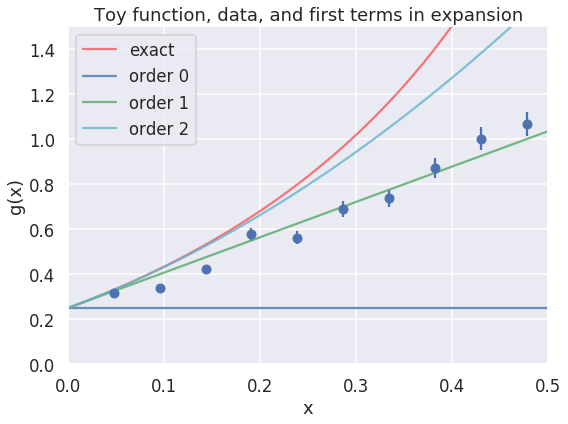

In [8]:
theta_true = np.array([0.25, 1.5707963, 2.4674011, 1.2919282, 4.0587121,
                       1.275082, 5.67486677])

# Generate data points as described in the paper; remember these are relative
#  errors, so multiply the percent by the data at each x. 
x_max = 1.5/np.pi   # we'll eventually test sensitivity to x_max
x_data_pts = np.linspace(x_max/10., x_max, 10) # don't start at x=0
eta = 0.05         # specified relative uncertainty is 5%

# Here we generate new (different) data points with every run
y_data_pts = g_fun(x_data_pts) * \
                  (1. + stats.norm.rvs(0., eta, size=len(x_data_pts)) )
# *** The following is the exact data with errors from the paper *** 
y_data_pts = np.array([0.31694, 0.33844, 0.42142, 0.57709, 0.56218, \
                        0.68851, 0.73625, 0.87270, 1.0015, 1.0684])

dy_data = eta * y_data_pts

# Always make a figure to check your data!
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.errorbar(x_data_pts, y_data_pts, dy_data, fmt='o')
ax.set_xlabel(r'x')
ax.set_ylabel(r'g(x)')
ax.set_xlim(0, 0.5)
ax.set_ylim(0, 1.5)

x_pts_all = np.arange(0., 1., .01)
ax.plot(x_pts_all, g_fun(x_pts_all), color='red', alpha=0.5, label='exact')
ax.set_title('Toy function, data, and first terms in expansion')

n_dim = 3
colors = ['b', 'g', 'c', 'm', 'k']
for order in range(n_dim):
    ax.plot(x_pts_all, y_model(x_pts_all, theta_true[:n_dim], order+1), 
            label=f'order {order:d}', color=colors[order], alpha=0.8)

ax.legend()
fig.tight_layout()

## Evidence calculation

Now we seek to reproduce and understand Figure 8 in the paper [*Bayesian parameter estimation for effective field theories*](https://arxiv.org/abs/1511.03618), which shows that the evidence for the model expansion up to order $\kmax$ *saturates* (i.e., increases up to a maximum and then flattens out close to that value).  This is in contrast to the more typical expectation from evidence calculations that lead to a definite peak.

The evidence can be expressed by marginalization as an integral over *all possible* $\avec$. (The notation with $k$ and $\kmax$ is for consistency with the paper; for our purposes today consider this as the evidence for an expansion up to order $k = \kmax$.)

$$
\begin{align}
\pr(D \mid k \leq \kmax, \kmax, I) &= \int d\abar \int d\avec \, \pr(D \mid \avec, k=\kmax, \kmax, I) \;
   \pr(\avec\mid\abar, I)\; \pr(\abar\mid I)
\end{align}
$$

*If you have a question about how this equations comes about, please ask!*

The first term in the integrand is the likelihood, which we saw above is a multivariate Gaussian and, in the present case with independent points, it is very simple, just the product of one-dimensional Gaussians.  If we take the case of a Gaussian prior for $\avec$ and the fixed (delta function) prior for $\abar$, we can do the $\abar$ integral for free and the remaining integral for the evidence can be done analytically.  

### Evidence using linear algebra and Gaussian integrals

If we write the multivariate Gaussians in the evidence in matrix form, we can use the basic formula for integration:

$$
\int e^{-\frac12 x^T A x + B^T x}\, d^nx = \sqrt{\det (2\pi A^{-1})} \; e^{\frac12 B^T A^{-1} B}
$$

where $x$ and $B$ are n-dimensional vectors and $A$ is an $n\times n$ matrix, with $n$ the number of data points.  The $x_i$ integrations are from $-\infty$ to $+\infty$.

### Evidence using conjugate prior

The usefulness of a conjugate prior is in carrying out a Bayesian update without having to do any calculation.  Recall yet again how Bayes theorem tells us how to update (the information $I$ will be implicit in the following):

$$
\pr(\theta\mid D) = \frac{\pr(D\mid\theta)\; \pr(\theta)}{\pr(D)}  
$$

If $\pr(\theta)$ is a conjugate prior to the likelihood, the updating consists solely of changing the parameters that specify the prior pdf.

The most complete table of conjugate priors out in the wild seems to be the Wikipedia webpage [Conjugate Prior](https://en.wikipedia.org/wiki/Conjugate_prior#Table_of_conjugate_distributions).  Take a look!

In [4]:
def make_matrices(x_pts, y_pts, dy_pts, k_order, a_bar):
    """
    Construct and return the matrices we'll need to calculate the evidence.  
    We have only one observable for now, so d is omitted.
    """
    m = k_order + 1   # number of coefficients is one more than the order
        
    A_mat = np.array( [[x**i for x in x_pts] for i in range(m)] ).T
    Sigma_mat = np.diag(dy_pts**2)
    Vp_mat = a_bar**2 * np.eye(m)
    y_vec = y_pts
    
    return A_mat, Sigma_mat, Vp_mat, y_vec          

def gaussian_norm(cov_mat):
    """Return the normalization factor for Gaussians.
       You can decide whether to use a covariance matrix or its inverse."""
    return 1. / np.sqrt(linalg.det(2. * np.pi * cov_mat))


0 []
1 [0.20326839]
2 [0.24989108 1.05424376]
3 [0.25497722 0.94121779 2.0655571 ]
4 [ 0.25591232  0.92604373  2.07904791 -0.58182149]
5 [ 0.25600677  0.92524138  2.07068204 -0.54087435]
6 [ 0.25601476  0.92531692  2.06811857 -0.53405038]
7 [ 0.25601508  0.92537442  2.06730968 -0.53242417]
8 [ 0.25601476  0.92540323  2.06699958 -0.53189693]
9 [ 0.25601453  0.9254159   2.06688069 -0.53171638]


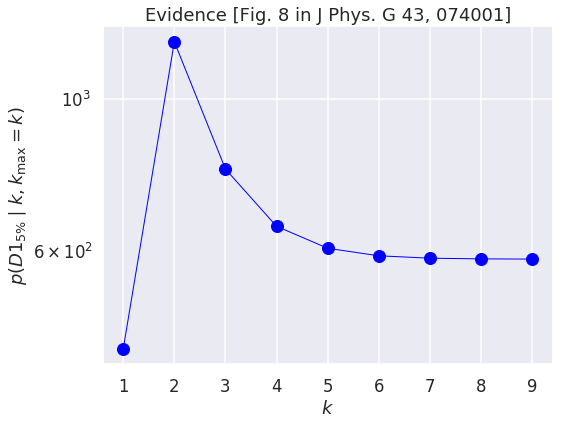

In [5]:
# step through the orders
k_max = 10
k_orders = range(k_max)

evidence = np.zeros(k_max)
for k_order in k_orders:
    a_bar = 5.
    A_mat, Sigma_mat, Vp_mat, y_vec = make_matrices(x_data_pts, y_data_pts, 
                                                    dy_data, k_order, a_bar)
        
    Sigma_mat_inv = linalg.inv(Sigma_mat)
    
    Lambda_mat = A_mat.T @ Sigma_mat_inv @ A_mat + linalg.inv(Vp_mat)
    Lambda_mat_inv = linalg.inv(Lambda_mat)
    
    Vp_mat_inv = linalg.inv(Vp_mat)
    
    a_hat = Lambda_mat_inv @ A_mat.T @ Sigma_mat_inv @ y_vec
    #print(f'k = {k_order}  a[k] = {a_hat:.2f}')
    print(k_order, a_hat[0:min(k_order,4)])
    
    chisq_min = (y_vec - A_mat @ a_hat).T @ Sigma_mat_inv @ \
                (y_vec - A_mat @ a_hat)
    
    evidence[k_order] = np.sqrt(linalg.det(2.*np.pi*Lambda_mat_inv)) \
                        * gaussian_norm(Sigma_mat) * np.exp(-chisq_min / 2.) \
                        * gaussian_norm(Vp_mat) \
                        * np.exp(- a_hat.T @ Vp_mat_inv @ a_hat / 2.) 
    
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(k_orders[1:], evidence[1:], color='blue', marker='o', 
        linestyle='solid', linewidth=1, markersize=12)
ax.set_title('Evidence [Fig. 8 in J Phys. G 43, 074001]')
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$p(D1_{5\%} \mid k, k_{\rm max}=k)$')
ax.set_yscale("log")
fig.tight_layout()

## Things for you to do:
* What do you expect to happen if you increase the range of data (set by `x_max` at the upper end)?  Do it and comment on the plots.
<br><br>
* What do you expect to happen if you change (first decrease, then increase) the relative error at each point? Do it and comment on the plots.
<br><br>
* What happens if you comment the definition of `y_data_pts` that uses the exact data from the paper and instead generate the noise randomly.  Does the pattern of the evidence change?  Does the magnitude of the evidence change?
<br><br>


## Notes
* The simple expression for $\hat a$ here, which minimizes $\chi^2$ (or, equivalently, maximizes the likelihood), analytically reproduces the results we worked hard for earlier to get by sampling.  The point of the latter exercise was to illustrate in a checkable problem how to do sampling, not because it was required in this case.
* Show that you get the same results.
* What can you say about the sampling?